In [1]:
import os
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from DataManager import DataManager
from utils.functions import rank_features
from utils.plotting import plot_rectangles
from utils.constants import features_categories

In [2]:
# Load the data and retrieve the control samples
dm = DataManager()
control_samples = dm.get_control_samples()

In [3]:
# Standardize the feature values
scaler = StandardScaler()
scaler.fit(dm.data.values[:,3:])
standardized_data = scaler.transform(dm.data.values[:,3:])

In [4]:
# Select the dimension of the embedding
hidden_dim = 6

In [5]:
## In order to train a new autoencoder, uncomment and run this cell

# p_dropout = 0.15
# encoder_layers = [nn.Linear(385, 128), nn.SELU(), nn.Dropout(p_dropout), nn.Linear(128, hidden_dim), nn.SELU()]
# decoder_layers = [nn.Linear(hidden_dim, 128), nn.SELU(), nn.Dropout(p_dropout), nn.Linear(128, 256), nn.SELU(), 
#                   nn.Dropout(p_dropout), nn.Linear(256, 385)]
# ae_model = Autoencoder(encoder_layers, decoder_layers)
# train_params = {"lr": 1e-4, "patience": 10, "epochs": 100}
# train_autoencoder(ae_model, standardized_data, train_params)

In [6]:
## Load the pretrained model used to generate the figures in the paper

def load_model_from_folder(folder_name, extension=".pt"):
    model = None
    for fname in os.listdir(folder_name):
        if fname.endswith(extension):
            model = torch.load(os.path.join(folder_name, fname))
            return model
    if model is None:
        raise ValueError("Invalid folder, no model found")
        
ae_model = load_model_from_folder(os.path.join("models", "trained_models", "Autoencoder"))

In [7]:
# Embed the dataset
ae_embedding = ae_model.encode(standardized_data).detach().numpy()
min_components = np.min(ae_embedding, axis=0)
max_components = np.max(ae_embedding, axis=0)

In [8]:
def map_trajectory(starting_point, encoder, decoder, component=0, component_range=[-1,1], N=50):
    representation = encoder(starting_point).flatten()
    if len(representation) <= component:
        raise ValueError("Invalid component to modify")
    component_values = np.linspace(*component_range, N)
    trajectory = []
    for v in component_values:
        representation[component] = v
        trajectory.append(decoder(representation))
    return np.array(trajectory)

def select_features(data_matrix, N=20, features=None, feature_categories=None, criterion="normalized_std"):
    assert (features is not None and features_categories is not None), "Missing features information"
    sorted_idxs = rank_features(data_matrix, criterion=criterion)
    ranked_features = [features[i] for i in sorted_idxs[:N]]
    
    ordered_features = []
    selected_ftrs_categories = OrderedDict()
    for category, cat_ftrs in features_categories.items():
        selected_cat_ftrs = sorted([f for f in ranked_features if f in cat_ftrs])
        if len(selected_cat_ftrs)>0:
            ordered_features.extend(selected_cat_ftrs)
            selected_ftrs_categories[category] = len(selected_cat_ftrs)
    return ordered_features, selected_ftrs_categories
    
def calculate_parallel_plot_ftrs(trajectory, features_dataframe, ftrs, control=None):
    if control is not None:
        avg_control_ftrs = np.array(features_dataframe.iloc[control].mean())
        trajectory = np.subtract(trajectory, avg_control_ftrs)
    
    
    ftr_idxs = [list(features_dataframe.columns).index(f) for f in ftrs]
    parallel_features = trajectory[:,np.array(ftr_idxs)]
    return parallel_features

In [12]:
def plot_trajectory_pc(model, component, n_samples = 100, N=50, cmap=cm.plasma, seed=4346):
    def encode(x):
        x=scaler.transform(x)
        return model.encode(x).detach().numpy()

    def decode(x):
        x = model.decode(x).detach().numpy()
        return scaler.inverse_transform(x)
    

    np.random.seed(seed)
    selected_samples = np.random.choice(range(len(dm.data)), n_samples, replace=False)
    component_range = [min_components[component], max_components[component]]

    trajectory = np.zeros((N, 385))
    for sample in selected_samples:
        selected_sample_ftrs = dm.data.iloc[sample]
        selected_sample_ftrs = np.array(selected_sample_ftrs[3:]).reshape(1,-1)

        trajectory += map_trajectory(list(selected_sample_ftrs), encode, decode, 
                                component=component, component_range=component_range, N=N)

    trajectory /= n_samples

    sel_features, sel_feature_categories = select_features(trajectory, N=20, features=dm.features, 
                                                         feature_categories=features_categories,
                                                         criterion="variance")
    parallel_features = calculate_parallel_plot_ftrs(trajectory, 
                                                     dm.data.drop(["drug", "cell_line", "replicate"], axis=1), 
                                                 sel_features, control=control_samples)
    max_val = np.amax(np.abs(parallel_features))
    
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    ax0 = fig.add_axes([0.79,0.25,0.05,0.5], frameon=False)
    ax1 = fig.add_axes([0.1,0.25,0.70,0.5], frameon=False)

    colors = cmap(np.linspace(0, 1, len(trajectory)))

    norm = mpl.colors.Normalize(vmin=component_range[0], vmax=component_range[1])

    cbar = mpl.colorbar.ColorbarBase(ax0, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')  
    cbar.set_label("Component {} value".format(component), rotation=90, labelpad=10)
    fig.suptitle("Component {}".format(component+1), fontsize=30)


    ax1.set_ylim(-max_val -0.5, max_val+0.5)
    ax1.set_frame_on(False)
    xx = range(len(sel_features))
    ax1.grid(axis="x")
    ax1.hlines(0,xx[0]-0.5,xx[-1]+0.5)
    ax1.set_xticks(xx)
    categories_idxs = [list(dm.features_categories.keys()).index(k) for k in sel_feature_categories.keys()]
    plot_rectangles(ax1, sel_feature_categories, color_idxs=categories_idxs)
    ax1.set_xticklabels(sel_features, rotation=45, ha='right')
    for i in range(len(trajectory)):
        ax1.plot(xx, parallel_features[i, :],
                      '-', linewidth=3, color=colors[i])
    return fig

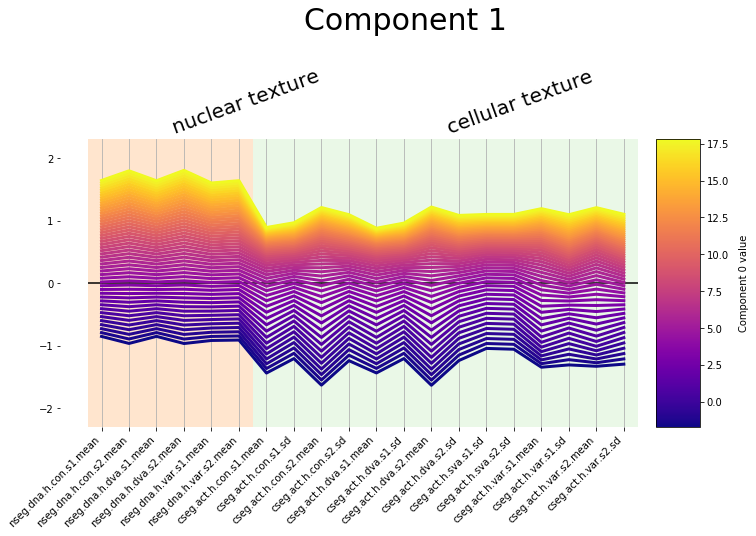

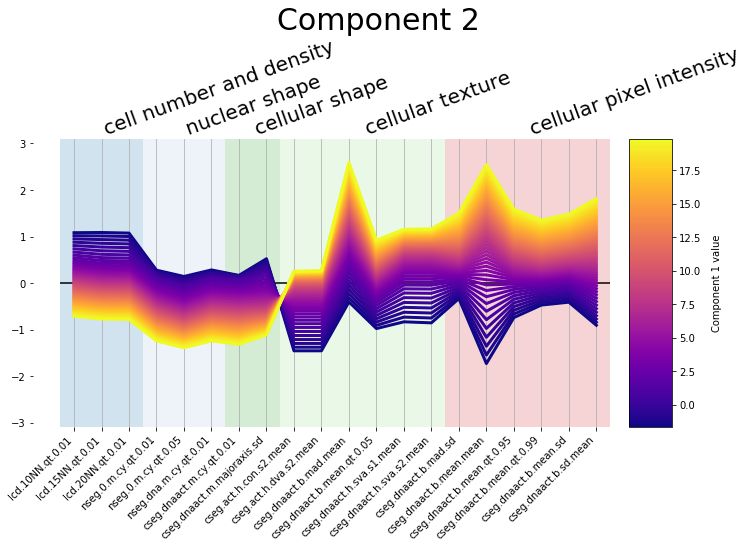

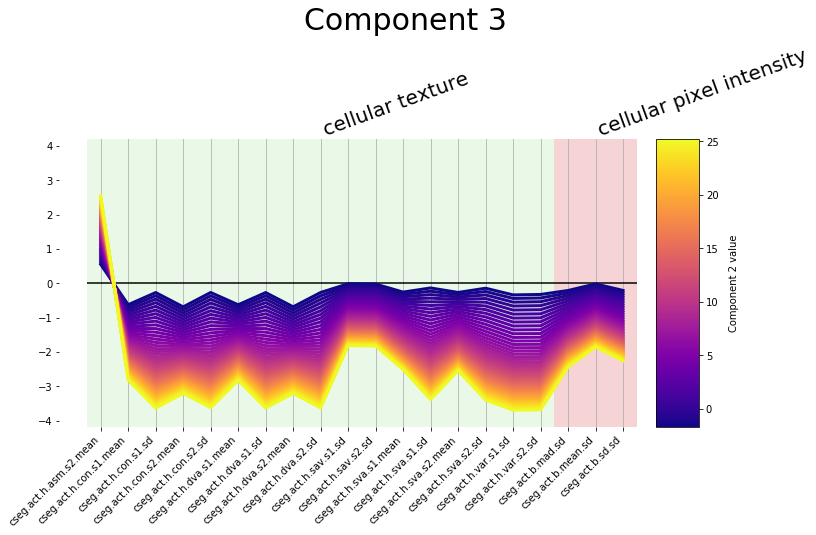

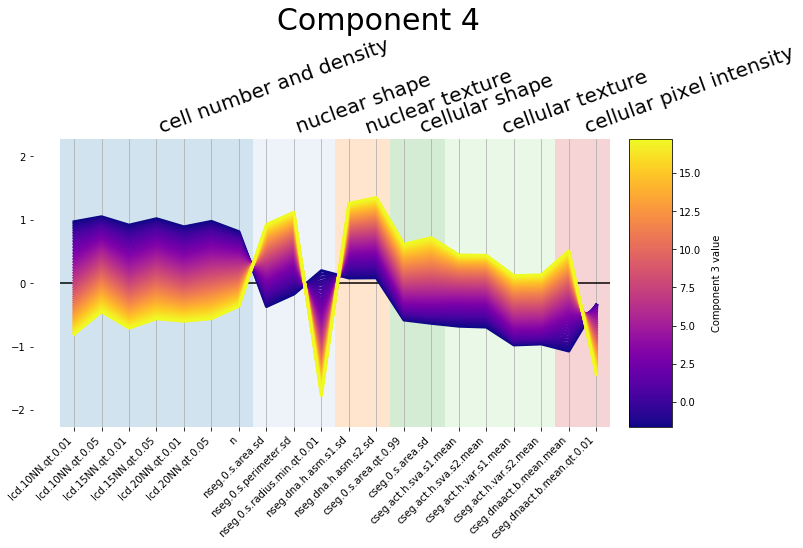

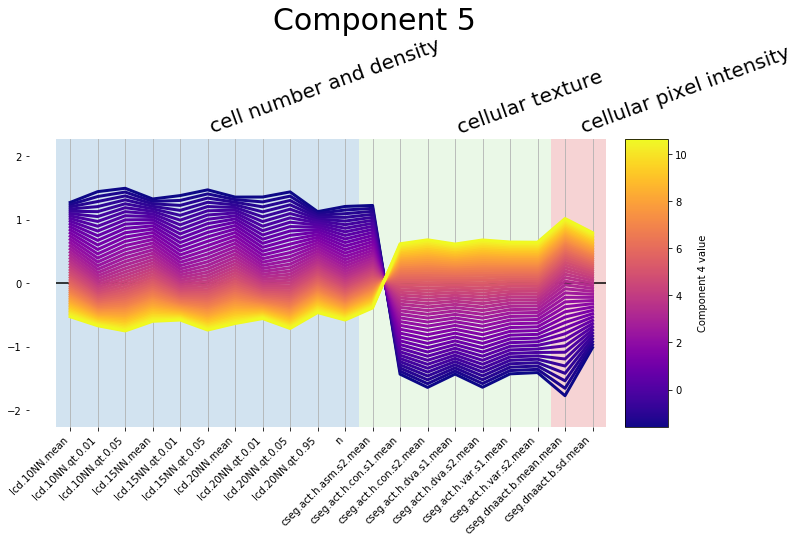

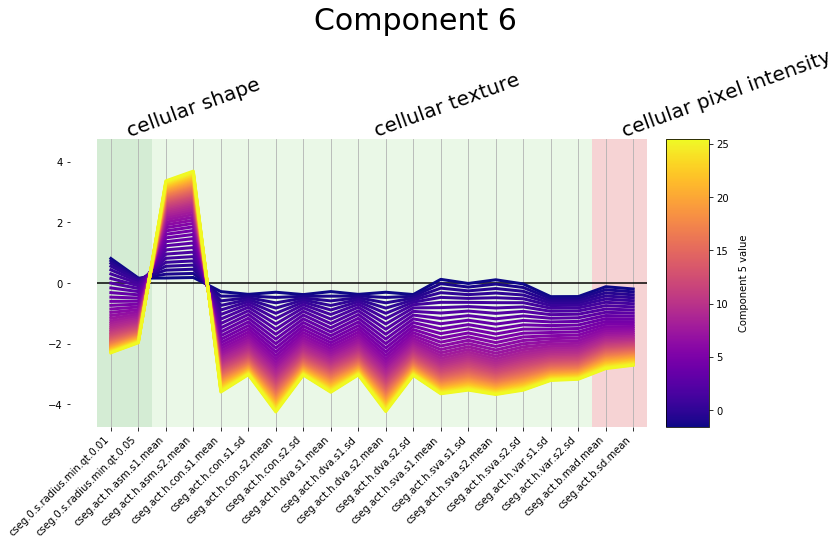

In [13]:
for component in range(hidden_dim):
    fig = plot_trajectory_pc(ae_model, component)
    
    fig.savefig(os.path.join(dm.output_folder, "AvgTrajectory", str(component) + ".pdf"))